In [1]:
#  notebook for testing the embedding obtained via Get_Results

# path where the data is saved, classes should correspond to folders in this directory
data_path = 'cifar100_reduced'

# select the model (pretrained on ImageNet) that was used for transfer learning
# allowed values: ResNet, EffNet, MobNet
model_name = 'ResNet'

# select the size that the input images were resized to
input_size = 224

# select the batch size used for training
batch_size = 16

# select the number of epochs
number_epochs = 100

# select the learning rate
learning_rate = 0.01

# define the path of the model to load based on the specified parameters
load_path = 'Model_' + model_name + '_' + str(input_size)+ '_' + str(batch_size)+ '_' + str(number_epochs)+ '_' + str(learning_rate)

In [2]:
# import the necessary packages

import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.spatial.distance import cdist
import torch.nn as nn
import numpy as np

In [3]:
# set device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# create class embeddings (may take a few minutes)

from Create_Class_Embeddings import create_class_embeddings

class_embeddings = create_class_embeddings(data_path)
class_embeddings = torch.from_numpy(class_embeddings).float().to(device)

C:\Users\marce\Python\Test\Create_Class_Embeddings.py:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  current_embedding = np.linalg.lstsq(matrix_prev_embeddings,distance_vector)[0]


In [5]:
# define model and load the trained model

from Select_Model import select_model

number_classes = class_embeddings.shape[0]
model_ft = None
model_ft = select_model(model_name,number_classes,device)

model_ft.load_state_dict(torch.load(load_path))

<All keys matched successfully>

In [6]:
# create complete dataloaders for testing the embedding

from Create_Dataloaders import create_dataloaders

dataloaders_dict = create_dataloaders(data_path,input_size,number_classes)

In [7]:
# get complete batch, sort it and put it through the network

images_val, labels_val = next(iter(dataloaders_dict['test']))

order = torch.argsort(labels_val)
labels_val = labels_val[order]
images_val = images_val[order,:,:,:]

images_val = images_val.to(device)

outputs = model_ft(images_val)

outputs = nn.functional.normalize(outputs,p=2,dim=1)

C:\Users\marce\anaconda3\envs\seminar\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [8]:
# compute the distance matrix

classes = class_embeddings.to('cpu').detach()
out = outputs.to('cpu').detach()
dists = cdist(out,classes)

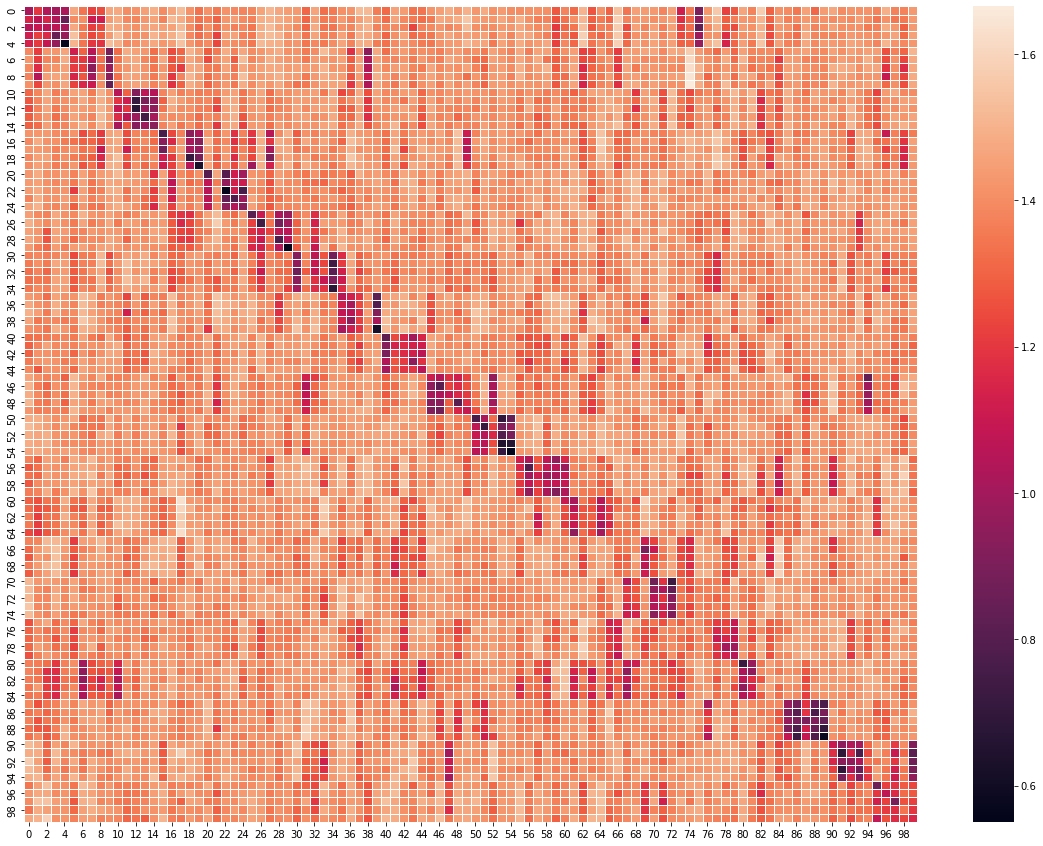

In [9]:
# plot the distances with the test classes on the x axis and the embeddings on the y axis

dists = np.transpose(dists)
plt.figure(figsize=(20, 15))
ax = sns.heatmap(dists, linewidth=0.5)
plt.show()